In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
# Modeling
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from ecallisto_dataset import (
    preprocess_spectrogram,
    EcallistoDatasetBinary,
    CustomSpecAugment,
    custom_resize,
    TimeWarpAugmenter
)

import pandas as pd

print(f'PyTorch version {torch.__version__}')
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("GPU is not available.")
    device = 'cpu'

/home/vincenzo/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.3.0+cu121
GPU is not available.


In [2]:
ds = load_dataset('i4ds/radio-sunburst-ecallisto-paths-df')

In [3]:
ds_burst = ds['test'].filter(lambda x: x['label'])

In [4]:
ds_burst

Dataset({
    features: ['file_path', 'label', 'antenna', 'datetime'],
    num_rows: 2862
})

In [11]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize(x, (224, 224)),  # Resize the image
    ]
)
data_augm_transform = Compose(
    [
        CustomSpecAugment(
            frequency_masking_para=56, method='random'
        ),
        TimeWarpAugmenter(50)
    ]
)

In [12]:
# Transforms

# Data Loader
ds_test = EcallistoDatasetBinary(
    ds_burst,
    resize_func=resize_func,
    data_augm_transform=data_augm_transform,
    normalization_transform=preprocess_spectrogram,
)


test_dataloader = DataLoader(
    ds_test,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    persistent_workers=False,
)


In [13]:
with torch.no_grad():
    for example in test_dataloader:
        example = example
        break

In [14]:
IDX = 21

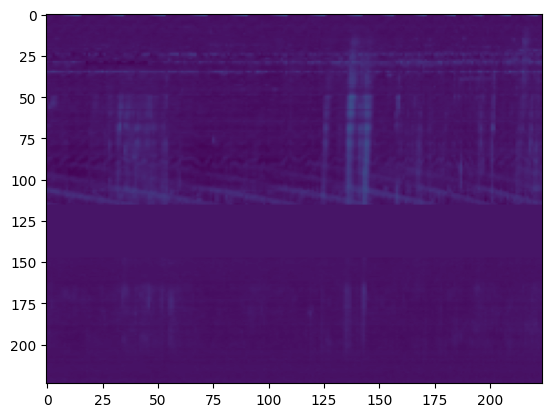

In [15]:
plt.imshow(example[0][IDX].squeeze(), aspect='auto')

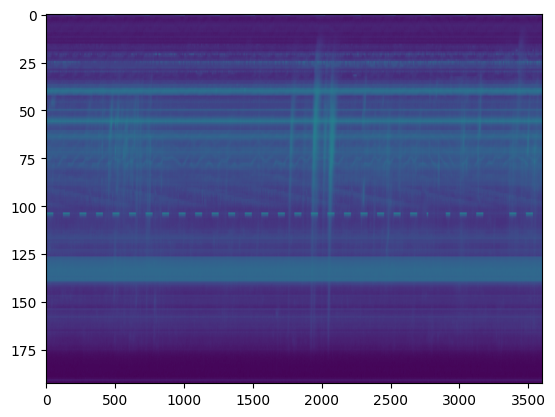

In [16]:
df = pd.read_parquet(ds_burst[IDX]['file_path'])
plt.imshow(df.T, aspect='auto')

In [12]:
import pandas as pd
import glob
import os
import time
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def check_parquet_for_nans(file_path):
    try:
        df = pd.read_parquet(file_path)
        if df.isna().any().any():
            return file_path
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return None

def find_parquet_files_with_nans(directory):
    parquet_files_with_nans = []

    # Use glob to find all Parquet files in the directory and subdirectories
    parquet_files = glob.glob(os.path.join(directory, '**', '*.parquet'), recursive=True)

    # Use multiprocessing to check each file with a progress bar
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm(pool.imap(check_parquet_for_nans, parquet_files), total=len(parquet_files), desc="Checking Parquet files"))

    # Filter out None results
    parquet_files_with_nans = [file for file in results if file is not None]

    return parquet_files_with_nans

# Set the directory you want to search
directory = "/mnt/nas05/data01/vincenzo/ecallisto/data"

# Find and print Parquet files with NaNs
files_with_nans = find_parquet_files_with_nans(directory)
if not files_with_nans:
    print("No Parquet files with NaNs found.")
else:
    print(f"Parquet files with NaNs:\n{files_with_nans}")


Checking Parquet files: 100%|██████████| 304760/304760 [29:11<00:00, 174.05it/s]


Parquet files with NaNs:
['/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-HAARP_62/0/2022-05-14_04-18-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-HAARP_62/0/2022-05-14_04-38-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/3/2024-04-17_16-43-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/0/2021-09-15_06-29-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/0/2021-09-15_06-19-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2022-05-12_22-13-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/NORWAY-EGERSUND_01/0/2022-12-15_13-27-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2021-03-31_08-40-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2022-06-15_08-43-00.parquet', '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2022-05-19_07-20-00.parquet']


In [13]:
files_with_nans

['/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-HAARP_62/0/2022-05-14_04-18-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-HAARP_62/0/2022-05-14_04-38-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/3/2024-04-17_16-43-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/0/2021-09-15_06-29-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_61/0/2021-09-15_06-19-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2022-05-12_22-13-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/NORWAY-EGERSUND_01/0/2022-12-15_13-27-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2021-03-31_08-40-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2022-06-15_08-43-00.parquet',
 '/mnt/nas05/data01/vincenzo/ecallisto/data/TRIEST_57/0/2022-05-19_07-20-00.parquet']